### Implementación del método DeepSurv usando la biblioteca PyCox

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
#from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import joblib

Adicionando una semilla para reproductibilidad

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

#### Conjunto de datos
Usando conjunto de datos preprocesados sobre datos de empresas españolas en el período 1999-2020

In [3]:
df = pd.read_csv('./../datasets/arhv_prepro_5.0.csv')
df

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,F36,F37,F38,F39,F40,F41,F42,F43,event,time
0,0,0,1.0,1.0,0,0,0,0,0,0,...,0.104192,0.023926,1.305501,0.260649,0.122838,-0.060748,1.227461,-0.033476,0,21.0
1,0,40,2.0,1.0,1,0,0,2,0,0,...,0.187715,0.151417,0.626269,0.132299,0.251000,0.013268,-0.292335,-0.006962,0,22.0
2,0,18,2.0,1.0,0,0,0,0,0,0,...,0.385539,0.336895,1.361841,0.594791,0.949946,-0.011401,-1.925450,-0.017829,0,22.0
3,19,7,0.0,1.0,0,0,0,0,0,0,...,0.596548,0.407431,1.593357,0.224175,0.643866,0.031109,-0.442274,-0.027099,1,14.0
4,19,0,2.0,1.0,0,0,0,0,0,0,...,0.123080,0.117009,0.793149,0.381961,0.942754,0.003329,-0.745527,-0.009753,1,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6376,18,16,1.0,0.0,0,0,0,1,0,0,...,0.190463,0.168681,1.046977,0.091520,0.093166,-0.013568,-2.566817,-0.022228,1,9.0
6377,13,13,3.0,0.0,0,0,0,1,0,0,...,0.298466,0.133987,0.314466,0.145075,0.717814,0.065671,-0.155346,-0.015047,1,12.0
6378,11,11,1.0,0.0,0,0,0,1,0,0,...,0.124445,0.065487,0.977181,0.165864,0.017639,-0.008573,-1.151375,-0.043251,1,9.0
6379,9,5,1.0,0.0,0,0,0,0,0,0,...,0.000000,0.000000,0.522243,0.152878,-0.100963,-0.010897,-1.877954,-0.019716,1,15.0


In [4]:
df_train = df
df_test = df.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

print(f"Train dataset stats: {df_train.shape}, Validation datasets stats: {df_val.shape}, Test dataset stats: {df_test.shape}")

Train dataset stats: (4084, 45), Validation datasets stats: (1021, 45), Test dataset stats: (1276, 45)


In [5]:
df_train.head()

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,F36,F37,F38,F39,F40,F41,F42,F43,event,time
0,0,0,1.0,1.0,0,0,0,0,0,0,...,0.104192,0.023926,1.305501,0.260649,0.122838,-0.060748,1.227461,-0.033476,0,21.0
1,0,40,2.0,1.0,1,0,0,2,0,0,...,0.187715,0.151417,0.626269,0.132299,0.251000,0.013268,-0.292335,-0.006962,0,22.0
2,0,18,2.0,1.0,0,0,0,0,0,0,...,0.385539,0.336895,1.361841,0.594791,0.949946,-0.011401,-1.925450,-0.017829,0,22.0
3,19,7,0.0,1.0,0,0,0,0,0,0,...,0.596548,0.407431,1.593357,0.224175,0.643866,0.031109,-0.442274,-0.027099,1,14.0
9,17,0,1.0,1.0,0,0,0,1,0,0,...,0.184629,0.098159,0.508884,0.184394,-0.056303,-0.022431,-3.495778,-0.031419,1,11.0


### Feature transforms

In [6]:
from sklearn.compose import ColumnTransformer
cols = df_train.columns.tolist()
cols.remove('event')
cols.remove('time')

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), cols)],
    remainder='passthrough',
    verbose_feature_names_out=False
)

x_train = preprocessor.fit_transform(df_train).astype('float32')
x_val = preprocessor.transform(df_val).astype('float32')
x_test = preprocessor.transform(df_test).astype('float32')

In [7]:
get_target = lambda df: (df['time'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

## Neural Network

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. Here, we just use the `torchtuples.practical.MLPVanilla` net to do this. Note that we set `out_features` to 1, and that we have not `output_bias`.

In [8]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)

#### Training the model
o train the model we need to define an optimizer. You can choose any torch.optim optimizer, but here we instead use one from tt.optim as it has some added functionality. We use the Adam optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186) to find a suitable learning rate with model.lr_finder

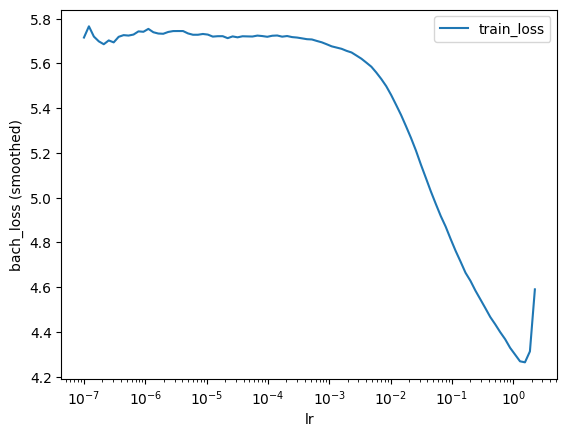

In [9]:
model = CoxPH(net, tt.optim.Adam)
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [10]:
lrfinder.get_best_lr()

np.float64(0.15556761439304817)

In [11]:
model.optimizer.set_lr(0.15556761439304817)

We include the EarlyStopping callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [12]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [13]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 3.5978,	val_loss: 14.9228
1:	[0s / 0s],		train_loss: 2.9296,	val_loss: 3.1077
2:	[0s / 0s],		train_loss: 2.6024,	val_loss: 2.2999
3:	[0s / 0s],		train_loss: 2.6039,	val_loss: 2.1576
4:	[0s / 0s],		train_loss: 2.3881,	val_loss: 2.1306
5:	[0s / 0s],		train_loss: 2.2935,	val_loss: 2.1139
6:	[0s / 0s],		train_loss: 2.2544,	val_loss: 2.1033
7:	[0s / 0s],		train_loss: 2.2188,	val_loss: 2.0663
8:	[0s / 0s],		train_loss: 2.1941,	val_loss: 1.9945
9:	[0s / 0s],		train_loss: 2.1907,	val_loss: 2.0115
10:	[0s / 0s],		train_loss: 2.1704,	val_loss: 2.0681
11:	[0s / 0s],		train_loss: 2.1343,	val_loss: 1.9911
12:	[0s / 0s],		train_loss: 2.1188,	val_loss: 2.0293
13:	[0s / 0s],		train_loss: 2.1401,	val_loss: 2.0590
14:	[0s / 0s],		train_loss: 2.2551,	val_loss: 2.0895
15:	[0s / 0s],		train_loss: 2.1809,	val_loss: 2.0539
16:	[0s / 1s],		train_loss: 2.2144,	val_loss: 2.0145
17:	[0s / 1s],		train_loss: 2.1990,	val_loss: 2.0917
18:	[0s / 1s],		train_loss: 2.1365,	val_loss: 2.0168
19

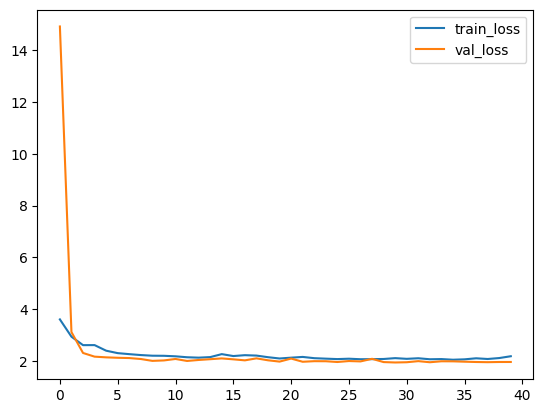

In [14]:
_ = log.plot()

In [15]:
model.partial_log_likelihood(*val).mean()

np.float32(-3.6685789)

### Predicción y evaluación
For evaluation we first need to obtain survival estimates for the test set. This can be done with model.predict_surv which returns an array of survival estimates, or with model.predict_surv_df which returns the survival estimates as a dataframe.

However, as CoxPH is semi-parametric, we first need to get the non-parametric baseline hazard estimates with compute_baseline_hazards.

Note that for large datasets the sample argument can be used to estimate the baseline hazard on a subset.

In [16]:
_ = model.compute_baseline_hazards()

In [17]:
baseline_hazards = model.baseline_hazards_
joblib.dump(baseline_hazards, 'baseline_hazards.joblib')

['baseline_hazards.joblib']

In [18]:
surv = model.predict_surv_df(x_test)

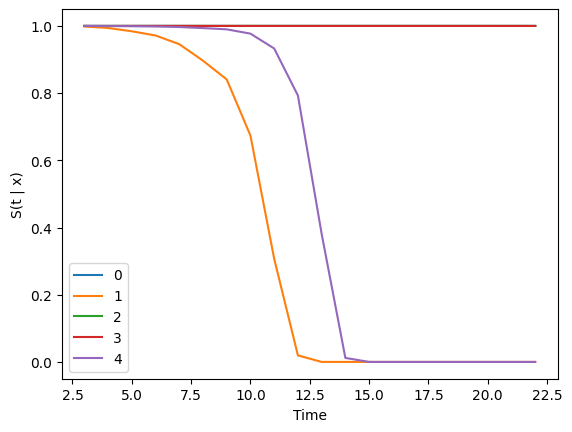

In [19]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

### Evaluation
We can use the EvalSurv class for evaluation the concordance, brier score and binomial log-likelihood. Setting censor_surv='km' means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [20]:
#parche por incompatibilidad
import scipy.integrate
if not hasattr(scipy.integrate, 'simps'):
    scipy.integrate.simps = scipy.integrate.simpson

In [21]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [22]:
joblib.dump(ev, './deepsurv_models/deppsurv_evaluation.joblib')

['./deepsurv_models/deppsurv_evaluation.joblib']

In [23]:
loaded_eval = joblib.load('./deepsurv_models/deppsurv_evaluation.joblib')

##### Concordance
We start with the event-time concordance by [Antolini et al. 2005.](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427)

In [25]:
ev.concordance_td()

0.981721859723046

In [26]:
loaded_eval.concordance_td()

0.981721859723046

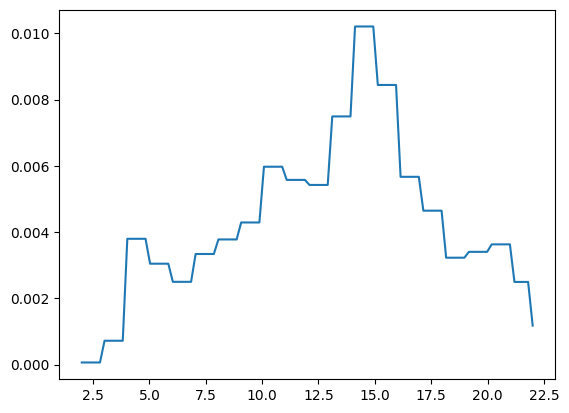

In [35]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

We can plot the the [IPCW Brier score](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5) for a given set of times. Here we just use 100 time-points between the min and max duration in the test set. Note that the score becomes unstable for the highest times. It is therefore common to disregard the rightmost part of the graph.

In [36]:
ev.integrated_brier_score(time_grid)

np.float64(0.004404215396064844)

Negative binomial log-likelihood
In a similar manner, we can plot the the [IPCW negative binomial log-likelihood](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

In [37]:
ev.integrated_nbll(time_grid)

np.float64(0.01839175303117756)

### Salvando el modelo entrenado
El objetivo es poder predecir nuevos casos

In [38]:
# Supón que tu modelo se llama `model` y ya está entrenado
#model.save_net("modelo_deepsurv.pt")

torch.save(model.net.state_dict(), "modelo_weights.pt")

In [39]:
import joblib
joblib.dump(preprocessor, 'preprocessor_deepsurv.pkl')

['preprocessor_deepsurv.pkl']

### Para hacer nuevas predicciones

Cargar el preprocesamiento

In [40]:
preprocessor = joblib.load("preprocessor_deepsurv.pkl")

Rehacer la arquitectura de la red neuronal

In [41]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)

In [42]:
from pycox.models import CoxPH
import torch
n_features = 45  # Cambia esto al número correcto de características
# Define la misma arquitectura que usaste al entrenar
net = tt.practical.MLPVanilla(
    in_features=n_features,
    num_nodes=[32, 32],
    out_features = 1,
    batch_norm=True,
    dropout=0.1,
    output_bias=False
)

# Crea una nueva instancia del modelo (sin entrenar)
state_dict = torch.load("modelo_weights.pt", weights_only=True)
net.load_state_dict(state_dict)

# 3. Crear el modelo de pycox
model_loaded = CoxPH(net)

In [47]:
loaded_baseline_hazards = joblib.load('baseline_hazards.joblib')
model_loaded.baseline_hazards_ = loaded_baseline_hazards
model_loaded.baseline_cumulative_hazards_ = model_loaded.compute_baseline_cumulative_hazards(
    set_hazards=False, 
    baseline_hazards_=loaded_baseline_hazards
)

In [50]:
X_new = pd.read_csv('./../datasets/to_predict.csv')
X_new_scaled = preprocessor.transform(X_new).astype('float32')
log_risk = model_loaded.predict(X_new_scaled)
print(f"Log Risk: {log_risk}")
surv = model_loaded.predict_surv_df(X_new_scaled)
risk = np.exp(log_risk)
print(f"Risk: {risk}")

Log Risk: [[-0.8999406 ]
 [ 0.49104282]
 [ 0.15455446]]
Risk: [[0.4065938]
 [1.6340193]
 [1.1671379]]


In [52]:
surv.head()

,0,1,2
duration,,,
3.0,0.999995,0.999978,0.999985
4.0,0.999982,0.999927,0.999948
5.0,0.999953,0.999809,0.999864
6.0,0.999915,0.999657,0.999755
7.0,0.999835,0.999338,0.999527


<Figure size 640x480 with 0 Axes>

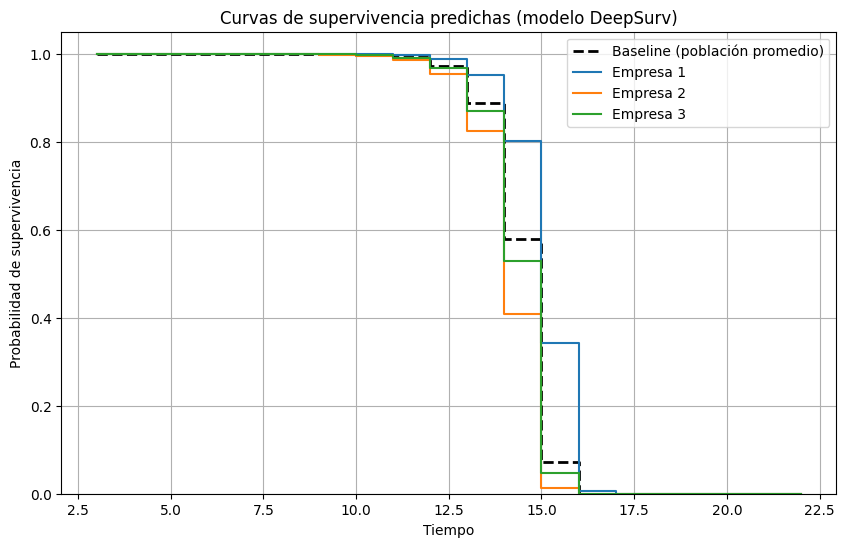

In [55]:
plt.figure()

# Obtener curvas de supervivencia para los nuevos pacientes
surv = model_loaded.predict_surv_df(X_new_scaled)

# Obtener la baseline survival: S0(t) = exp(-H0(t))
baseline_survival = np.exp(-model_loaded.baseline_cumulative_hazards_)

# Graficar
plt.figure(figsize=(10, 6))

# Línea dashed para la baseline
plt.step(
    baseline_survival.index,
    baseline_survival.values,
    where='post',
    label='Baseline (población promedio)',
    color='black',
    linestyle='--',
    linewidth=2
)

# Graficar cada curva
for i in range(surv.shape[1]):  # surv.shape[1] = número de pacientes
    plt.step(surv.index, surv.iloc[:, i], where='post', label=f'Empresa {i+1}')

plt.ylabel('Probabilidad de supervivencia')
plt.xlabel('Tiempo')
plt.title('Curvas de supervivencia predichas (modelo DeepSurv)')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()

### Predecir el valor medio de tiempo hasta la insolvencia
Se determina el momento cuando la probabilidad de supervivencia cae por debajo del 0.5 porciento

In [56]:
def predict_median_survival_time(model, X_single):
    surv = model.predict_surv_df(X_single)
    times = surv.index.values
    s = surv.iloc[:, 0].values
    idx = np.where(s <= 0.5)[0]
    return times[idx[0]] if len(idx) > 0 else np.inf

In [59]:
# Uso
for i in range(X_new_scaled.shape[0]):
    median_t = predict_median_survival_time(model_loaded, X_new_scaled[[i]])
    print(f"Mediana de supervivencia para la empresa {i+1}: {median_t:.1f} años")


Mediana de supervivencia para la empresa 1: 15.0 años
Mediana de supervivencia para la empresa 2: 14.0 años
Mediana de supervivencia para la empresa 3: 15.0 años
